# inicialização

In [7]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
import plotly.express as px
import os
import sys

sys.path.append("..")

from structureSelector import *
from methods.utils.utilities import *

def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (y + np.finfo(np.float64).eps))) * 100, 3)
    print('RMSE:', np.sqrt(np.mean(np.square(residuo1))),'\nMSE:', np.mean(np.square(residuo1)), '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')
    #cc = np.corrcoef(y, yest)

mat_content1 = sc.loadmat("../data/DATAPRBS.MAT")

u1 = mat_content1['u2']
z1 = mat_content1['z2']

zc1 = z1.copy()
l1 = np.array([32, 56, 75, 91, 107, 132, 161, 196, 231, 272, 292, 307, 337, 372, 388, 407, 436, 452, 472])
l2 = np.array([47, 64, 83, 99, 116, 153, 172, 223, 241, 286, 299, 314, 368, 382, 401, 422, 443, 466, 500])

for i in range(l1.shape[0]):
    zc1[l1[i]: l2[i]] *= -1

t = np.arange(0, 500, 1)#np.arange(0, 10, 0.02)
fig=px.line(x=t, y=np.squeeze(z1), height=400, width=1300)
fig.add_scatter(x=t, y=np.squeeze(zc1), mode='lines')
fig.add_scatter(x=t, y=np.squeeze(u1), mode='lines')
fig.show()


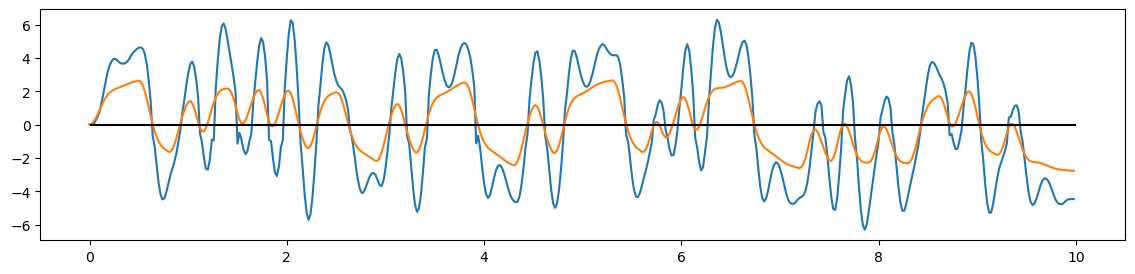

In [4]:
Y = np.zeros(z1.shape)
U = u1.copy()
Ts = 0.02

x1 = np.zeros(z1.shape)
x2 = np.zeros(z1.shape)
x3 = np.zeros(z1.shape)

c = np.array([[5017, -19.61, -504.2, -2747],
              [4015, -17.96, -463.7, -2094],
               [5174, -20.52, -512.5, -2931]])
j = 1
for i in range(1, z1.shape[0]):
    dx3 = c[j][0] * U[i-1] + c[j][1] * x3[i-1] + c[j][2] * x2[i-1] + c[j][3] * x1[i-1]
    x3[i] = x3[i-1] + Ts * dx3
    x2[i] = x2[i-1] + Ts * x3[i][0]
    x1[i] = x1[i-1] + Ts * x2[i][0]
    
    
zc1[32:47] *= -1
zc1[56:64] *= -1
zc1[75:83] *= -1
zc1[91:99] *= -1
zc1[107:116] *= -1
zc1[132:153] *= -1
zc1[161:172] *= -1
zc1[196:223] *= -1
zc1[231:241] *= -1
zc1[272:286] *= -1
zc1[292:299] *= -1
zc1[307:314] *= -1
zc1[337:368] *= -1
zc1[372:382] *= -1
zc1[388:401] *= -1
zc1[407:422] *= -1
zc1[436:443] *= -1
zc1[452:466] *= -1
zc1[472:] *= -1

tt = np.arange(0, 10, 0.02)
plt.figure(figsize=(14,3))
plt.plot(tt, zc1, label='Original')
#plt.plot(x1, label='Original')
s = np.sin(t/3 - np.pi/3) + x1[:, 0]
plt.plot(tt, x1)
plt.hlines(y=0, xmin=0, xmax=10, color='black')
plt.show()

# Estimação PRBS

[Y1.1 Y1.3 U1.6 U1.8 tanh(Y1.1) U1.3] [ 1.19136167 -0.32508351  0.19459342  0.25230939 -0.51233312  0.1677879 ]
0.167787901209538*U1.3 + 0.194593420286627*U1.6 + 0.252309386999801*U1.8 + 1.19136167474075*Y1.1 - 0.325083514565238*Y1.3 - 0.512333121862011*tanh(Y1.1)
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]


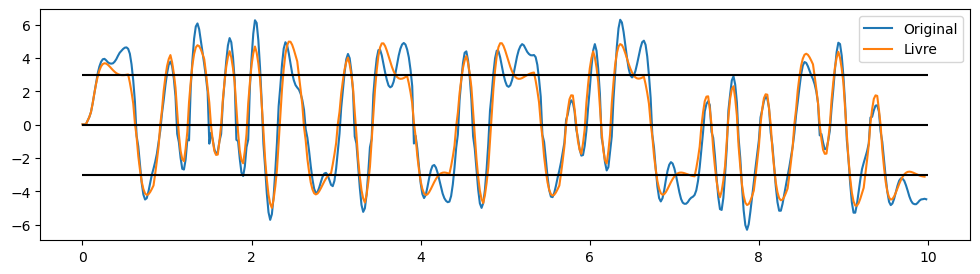


Simulação livre
RMSE: 0.9458556159729251 
MSE: 0.8946428462675217 
AET: 375.3932962568357 
MAPE: 35.352%

Um passo a frente
RMSE: 0.38757381868283663 
MSE: 0.15021346492839632 
AET: 130.9769516637971 
MAPE: 18.632%


"plt.plot(y[:, 0] - yhat, label='Livre')\nplt.legend()\nplt.show()"

In [16]:
output = 0  # 0 ou 1

y = zc1.copy()
u = u1.copy()
num = [9, 6]
params = []
params.append({'nb':[4],'na':[8], 'level':2, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9
#params.append({'nb':[2],'na':[6], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':2, 'diff':False}) #zc1 5
#params.append({'nb':[4],'na':[6], 'level':1,2
sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]
#theta[2] = theta[3]
print(model, theta)
print(model @ theta)

slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)


fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(12,3))
plt.plot(ts, y, label='Original')
#plt.plot(ts, u + u[0], label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], slivre[s:fim], label='Livre')
plt.hlines([3, 0, -3], 0, 10, colors='black')

plt.legend()
plt.show()

print("\nSimulação livre")
metrics(y[:, 0], slivre)
print("\nUm passo a frente")
metrics(y[:, 0], yhat)

'''plt.plot(y[:, 0] - yhat, label='Livre')
plt.legend()
plt.show()'''


## view

In [9]:
n = 1
u2 = mat_content1['u'+str(n)]
z2 = mat_content1['z'+str(n)]

t = np.arange(0, 500, 1)#np.arange(0, 10, 0.02)
fig=px.line(x=t, y=np.squeeze(z2), height=400, width=1300)
#fig.add_scatter(x=t, y=np.squeeze(x1), mode='lines')
fig.add_scatter(x=t, y=np.squeeze(u2), mode='lines')
#fig.add_scatter(x=t, y=np.squeeze(u1), mode='lines')
fig.show()

## Validação

Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]
Modelo selecionado:
0.167787901209538⋅U1.3 + 0.194593420286627⋅U1.6 + 0.252309386999801⋅U1.8 + 1.1
9136167474075⋅Y1.1 - 0.325083514565238⋅Y1.3 - 0.512333121862011⋅tanh(Y1.1)


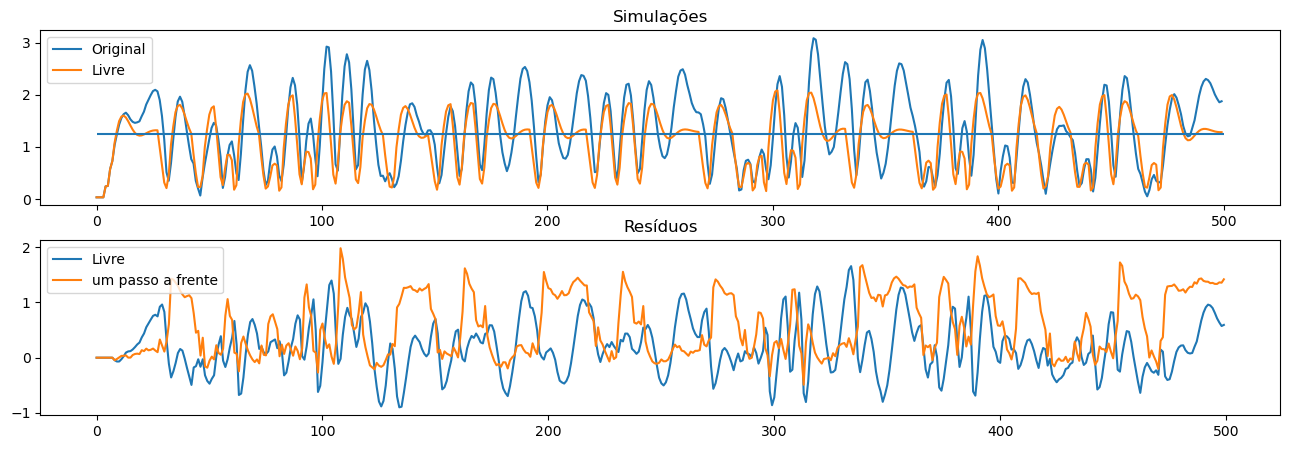


Simulação livre
RMSE: 1.9569979386032732 
MSE: 3.829840931697461 
AET: 725.9264595694672 
MAPE: 119.166%

Um passo a frente
RMSE: 0.7990849606891236 
MSE: 0.6385367743995382 
AET: 298.6067090969053 
MAPE: 57.999%


In [17]:
uVal = u2.T
yVal = z2.T

yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(np.abs(valLivre), label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].hlines(1.25, 0, 500)
ax[0].set_title("Simulações")
ax[0].legend()

ax[1].plot(yVal[output].T - np.abs(valLivre), label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

print("\nSimulação livre")
metrics(yVal[0, :], valLivre)
print("\nUm passo a frente")
metrics(yVal[0, :], yhat)


# Uniform

In [19]:
mat_content2 = sc.loadmat("../data/DATAUNIF.MAT")

print(mat_content2.keys())
u11 = mat_content2['u11']
z11 = mat_content2['z11']

u12 = mat_content2['u12']
z12 = mat_content2['z12']


t = np.arange(0, 500, 1)#np.arange(0, 10, 0.02)
fig=px.line(x=t, y=np.squeeze(z11), height=400, width=1300)
fig.add_scatter(x=t, y=np.squeeze(u11), mode='lines')
#fig.add_scatter(x=t, y=np.squeeze(zc11), mode='lines')

fig.show()
'''fig=px.line(x=t, y=np.squeeze(z12), height=400, width=1300)
fig.add_scatter(x=t, y=np.squeeze(z12), mode='lines')
fig.add_scatter(x=t, y=np.squeeze(u12), mode='lines')
fig.show()'''

dict_keys(['u11', 'u12', 'z11', 'z12'])


"fig=px.line(x=t, y=np.squeeze(z12), height=400, width=1300)\nfig.add_scatter(x=t, y=np.squeeze(z12), mode='lines')\nfig.add_scatter(x=t, y=np.squeeze(u12), mode='lines')\nfig.show()"

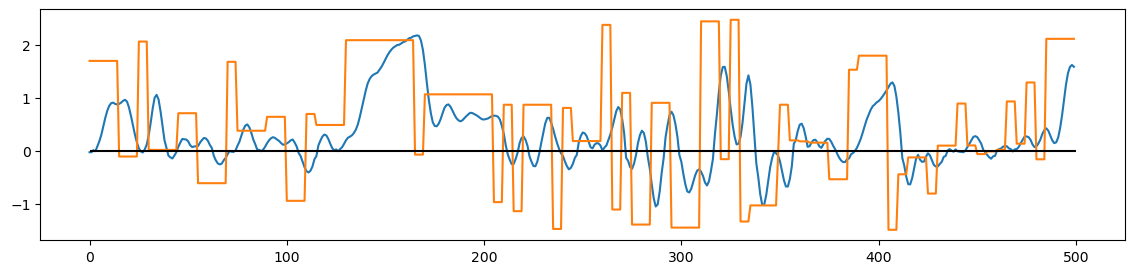

In [84]:
zc11 = z11.copy()
#l1 = np.array([40, 53, 106, 212, 223, 239, 272, 283, 299, 338, 379, 412, 454, 480])
#l2 = np.array([45, 73, 116, 218, 229, 248, 278, 292, 317, 347, 389, 435, 460, 490])
l1 = np.array([40, 63, 106, 212, 223, 239, 272, 283, 299, 338, 379, 412, 454])
l2 = np.array([45, 73, 116, 218, 229, 248, 278, 292, 317, 357, 389, 435, 460])


for i in range(l1.shape[0]):
    zc11[l1[i]: l2[i]] *= -1

plt.figure(figsize=(14,3))
plt.plot(zc11)
plt.plot(u11)
plt.hlines(0, 0, 500, colors='black')
plt.show()

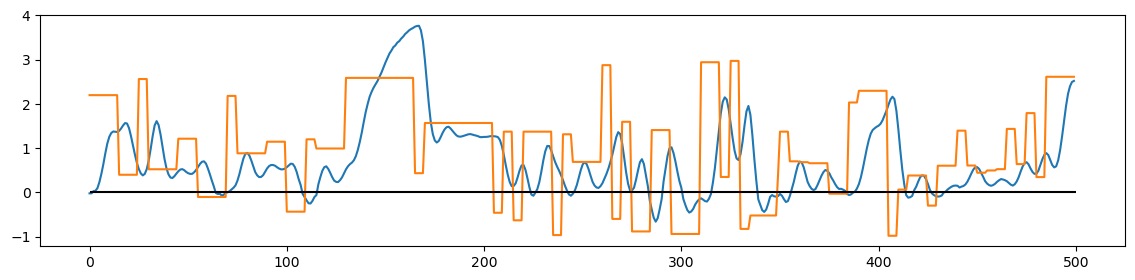

In [21]:
zc12 = z12.copy()
l1 = np.array([64, 108, 224, 243, 284, 301, 339, 384, 414, 427])
l2 = np.array([71, 116, 227, 246, 291, 316, 356, 388, 418, 434])

for i in range(l1.shape[0]):
    zc12[l1[i]: l2[i]] *= -1

plt.figure(figsize=(14,3))
plt.plot(zc12)
plt.plot(u12)
plt.hlines(0, 0, 500, colors='black')
plt.show()

## Estimação

[Y1.1 U1.4 Y1.6 U1.3*U1.7**2 Y1.3 U1.5*U1.8*Y1.6 U1.6 U1.5*U1.7*Y1.5] [ 1.29157508  0.02865433  0.10861507  0.00698795 -0.50545119  0.02537075
  0.01526338 -0.01711516]
0.00698794841356964*U1.3*U1.7**2 + 0.0286543347386335*U1.4 - 0.0171151553468142*U1.5*U1.7*Y1.5 + 0.0253707542244849*U1.5*U1.8*Y1.6 + 0.0152633807295483*U1.6 + 1.2915750803137*Y1.1 - 0.505451194320114*Y1.3 + 0.108615074673923*Y1.6
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]


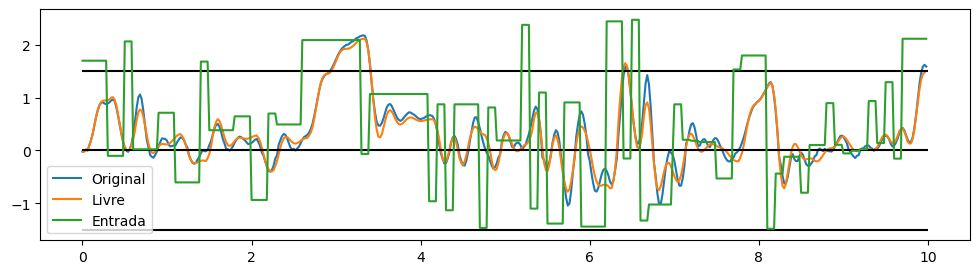


Simulação livre
RMSE: 0.385920321104274 
MSE: 0.14893449424122593 
AET: 104.52994000711932 
MAPE: 160.339%

Um passo a frente
RMSE: 0.04307020890636193 
MSE: 0.0018550428952376586 
AET: 14.127511379549222 
MAPE: 41.59%


In [85]:
output = 0  # 0 ou 1

y = zc11.copy()
u = u11.copy()
num = [9, 6]
params = []
params.append({'nb':[6],'na':[8], 'level':3, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

#params.append({'nb':[6],'na':[8], 'level':2, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]
#theta[2] = theta[3]
print(model, theta)
print(model @ theta)

slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)


fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(12,3))
plt.plot(ts, y, label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], slivre[s:fim], label='Livre')
plt.hlines([1.5, 0, -1.5], 0, 10, colors='black')
plt.plot(ts, u, label='Entrada')
plt.legend()
plt.show()

print("\nSimulação livre")
metrics(y[:, 0], np.abs(slivre))
print("\nUm passo a frente")
metrics(y[:, 0], yhat)
#Y1.1 Y1.2 Y1.4 U1.3 U1.4*Y1.1 Y1.3 Y1.6*tanh(Y1.1) U1.5*U1.6
#Y1.1 Y1.2 Y1.6 U1.3*U1.7**2 U1.4 Y1.3 U1.6*Y1.6 U1.1*U1.7*tanh(U1.1)

## Validação

Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]
Modelo selecionado:
                            2                                                 
0.0070739790539192⋅U1.3⋅U1.7  + 0.028738528401356⋅U1.4 - 0.0174717028799431⋅U1

                                                                              
.5⋅U1.7⋅Y1.5 + 0.0256956205275203⋅U1.5⋅U1.8⋅Y1.6 + 0.0163000992377437⋅U1.6 + 1

                                                                     
.28324083622416⋅Y1.1 - 0.497006766526877⋅Y1.3 + 0.10690848140274⋅Y1.6


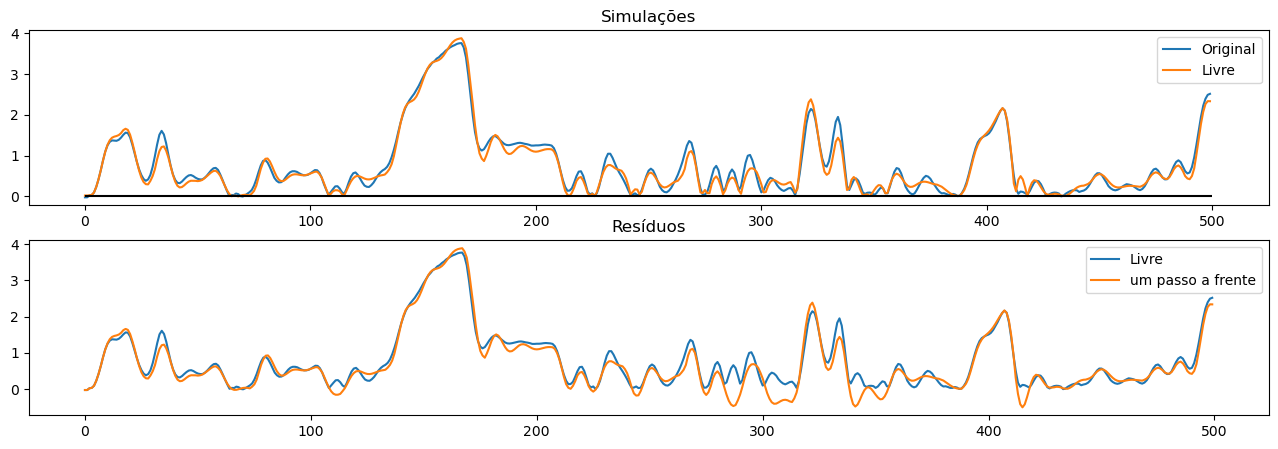


Simulação livre
RMSE: 0.13033065662664792 
MSE: 0.016986080056733202 
AET: 48.82084135289453 
MAPE: 37.697%

Um passo a frente
RMSE: 0.05470687863133211 
MSE: 0.002992842569583302 
AET: 16.436946539050993 
MAPE: 30.233%


In [83]:

uVal = u12.T
yVal = z12.T

yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
#ax[0].plot(valLivre, label='Livre')
ax[0].plot(np.abs(valLivre), label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()

ax[1].plot(yVal.T, label='Livre')
ax[1].plot(valLivre, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
'''ax[1].plot(yVal[output].T - np.abs(valLivre), label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()'''
plt.show()

print("\nSimulação livre")
metrics(yVal[0, :], np.abs(valLivre))
print("\nUm passo a frente")
metrics(yVal[0, :], yhat)


Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]
Modelo selecionado:
                                                                        2     
0.00766272998429804⋅U1.1⋅U1.7⋅tanh(U1.1) + 0.00463398651746354⋅U1.3⋅U1.7  + 0.

                                                                              
0295471369309655⋅U1.4 + 0.00520356242948974⋅U1.5⋅U1.8 + 0.0183656208296996⋅U1.

                                                                              
6⋅Y1.6 + 1.49070998933788⋅Y1.1 - 0.420884288405317⋅Y1.2 - 0.261528262737152⋅Y1

                           
.3 + 0.082456449579637⋅Y1.6


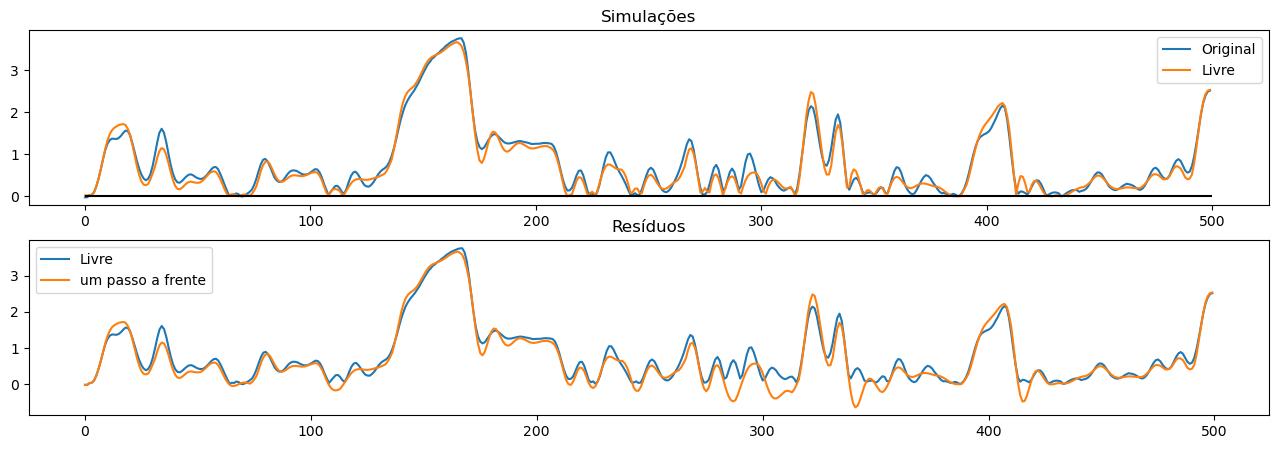


Simulação livre
RMSE: 0.13902932986358327 
MSE: 0.019329154562317045 
AET: 53.14680408784647 
MAPE: 36.658%

Um passo a frente
RMSE: 0.05058975290981314 
MSE: 0.0025593230994759475 
AET: 15.42509767979098 
MAPE: 29.074%


In [ ]:
'''uVal = np.ones(u1.T.shape) * 2#u1.T
uVal[0, 100:] = -3'''
uVal = u12.T
yVal = z12.T

yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
#ax[0].plot(valLivre, label='Livre')
ax[0].plot(np.abs(valLivre), label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()

ax[1].plot(yVal.T, label='Livre')
ax[1].plot(valLivre, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
'''ax[1].plot(yVal[output].T - np.abs(valLivre), label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()'''
plt.show()

print("\nSimulação livre")
metrics(yVal[0, :], np.abs(valLivre))
print("\nUm passo a frente")
metrics(yVal[0, :], yhat)
